Neural Point Process

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache
from tools.plot_utils import visualize_pins, plot_label_pin, plot_all, plot_and_save, plot_loss
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, train_model, evaluate_model
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
import time
from tools.models import *
from torch.utils.data import Subset

# Dataset and Visualization

In [3]:
# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

In [5]:
dataset = "PinMNIST"
feature_extracted = False
n = 10
mesh = True
d = 3
n_pins = 100
fixed_pins = True
r = 3
d1, d2 = 28, 28

partial_label_GP = False
partial_percent = 0.5

if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
    else:
        data_folder = f"./data/{folder}/random_fixedTrue_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"
elif dataset == "Synthetic":
    folder += "/28by28pixels_1000images_123456seed"
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_pins"
    else:
        data_folder = f"./data/{folder}/random_{n_pins}pins"
elif dataset == "Building":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}_step"
    else:
        data_folder = f"./data/{folder}/random_n_pins_{n_pins}"


In [6]:
if dataset == "Building":
    resize = Resize100
else:
    resize = Resize
        

# Define batch size
batch_size = 16

def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]

    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs}

transform = transforms.Compose([
        ToTensor(),  # Convert to tensor (as you were doing)
        resize()  # Resize to 100x100
    ])


modality = "PS-RGBNIR-SAR"
if dataset == "Building":
    root_dir = "/work/USACE_KRI/Project_1/spacenet/aoi_11_rotterdam/train/train/AOI_11_Rotterdam/"+modality+"/"
else:
    root_dir=f"./data/{folder}/images/"
    
transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                 root_dir=root_dir, modality=modality,
                                 transform=transform)


dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size


if os.path.exists(f"./data/{dataset}/train_indices.npy"):
    train_indices = np.load(f'./data/{dataset}/train_indices.npy')
    val_indices = np.load(f'./data/{dataset}/val_indices.npy')
    test_indices = np.load(f'./data/{dataset}/test_indices.npy')
    # Use the indices to create new datasets
    train_dataset = Subset(transformed_dataset, train_indices)
    val_dataset = Subset(transformed_dataset, val_indices)
    test_dataset = Subset(transformed_dataset, test_indices)
else:
    # Split the dataset into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(
        transformed_dataset, [train_size, val_size, test_size]
    )
    np.save(f'./data/{dataset}/train_indices.npy', train_dataset.indices)
    np.save(f'./data/{dataset}/val_indices.npy', val_dataset.indices)
    np.save(f'./data/{dataset}/test_indices.npy', test_dataset.indices)

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in test_loader:
    images = batch['image'].to(device) # get RGB instead of RGBA
    pins = batch['pins']
    outputs = batch['outputs']
    break

In [31]:
images.shape

torch.Size([16, 1, 28, 28])

torch.Size([28, 28]) torch.Size([28, 28])


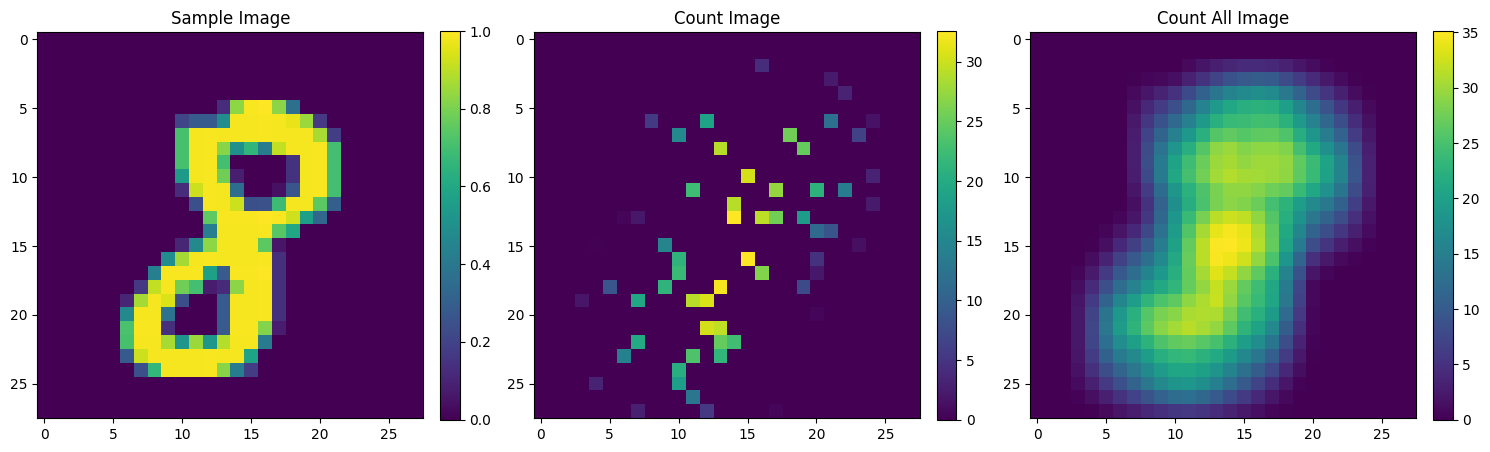

In [32]:
j=6
sample_img = images[j].squeeze().detach().cpu()
count_image = plot_label_pin(sample_img, pins[j], outputs[j])
count_all_image = plot_all(sample_img, r=3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# sample_img = sample_img[4:]
img = sample_img #np.transpose(sample_img, (1, 2, 0))
print(sample_img.shape, img.shape)
im0 = axes[0].imshow(img)
# Plot the sample_img in the first subplot
# im0 = axes[0].imshow(sample_img)
axes[0].set_title('Sample Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_image in the second subplot
im1 = axes[1].imshow(count_image)
axes[1].set_title('Count Image')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_all_image in the third subplot
im2 = axes[2].imshow(count_all_image)
axes[2].set_title('Count All Image')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)  # Add colorbar

# Add spacing between subplots
plt.tight_layout()
# Display the figure
plt.show()

In [38]:
!pwd

/work/DNAL/shi.cheng/NPP/Satellite_Fusion


In [43]:
model.load_state_dict(torch.load(f'./history/npp_manual_RBF/1720073196/best_model_NPP.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [34]:
pred = model(images.to(torch.float32))[j].squeeze().detach().cpu()

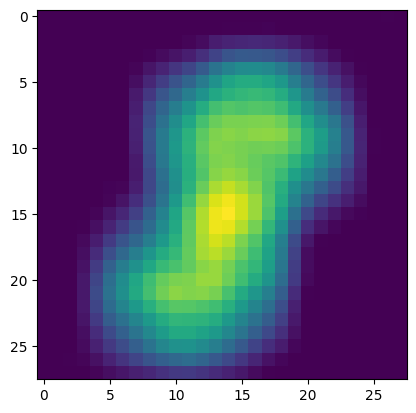

In [35]:
plt.imshow(pred)

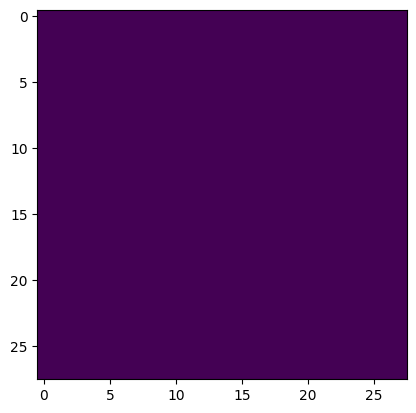

In [41]:
model.load_state_dict(torch.load(f'./history/Mesh_PinMNIST_0707/1720388260/best_model_MSE.pth', map_location=torch.device('cpu')))
pred = model(images.to(torch.float32))[j].squeeze().detach().cpu()
plt.imshow(pred)

# Training

In [8]:
class CustomLRFinder:
    def __init__(self, model, criterion, optimizer, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.history = {'lr': [], 'loss': []}

    def find_lr(self, train_loader, start_lr=1e-4, end_lr=0.1, num_iter=20,smooth_f=0.05):
        model = self.model.to(self.device)
        criterion = self.criterion
        optimizer = self.optimizer
        device = self.device
        model.train()

        lr_step = (end_lr / start_lr) ** (1 / num_iter)
        lr = start_lr

        for iteration in range(num_iter):
            optimizer.param_groups[0]['lr'] = lr

            total_loss = 0.0
            for batch in train_loader:
                x_train = batch['image'][:, :input_channel, :, :].to(device)
                p_train = [tensor.to(device) for tensor in batch['pins']]
                y_train = [tensor.to(device) for tensor in batch['outputs']]

                optimizer.zero_grad()
                outputs = model(x_train.float())
                loss = criterion(y_train, outputs, p_train)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.history['lr'].append(lr)
            self.history['loss'].append(avg_loss)

            lr *= lr_step
            
    def plot_lr_finder(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')  # Use a logarithmic scale for better visualization
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder Curve')
        plt.show()
        
    def find_best_lr(self, skip_start=3, skip_end=3):
        # Find the index of the minimum loss in the specified range
        min_loss_index = skip_start + np.argmin(self.history['loss'][skip_start:-skip_end])

        # Output the learning rate corresponding to the minimum loss
        best_lr = self.history['lr'][min_loss_index]
        return best_lr

In [44]:
# Case 1: identity=True
# Set your hyperparameters
input_channel = 1 if dataset == "PinMNIST" else 3
epochs = 20
sigmas = [0.1, 0.2, 0.5, 1, 2, 5]  # Set the sigma values you want to test
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
learning_rate = 0.01
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel, deeper=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# criterion_MSE = NPPLoss(identity=True).to(device)
# lr_finder_MSE = CustomLRFinder(model, criterion_MSE, optimizer, device=device)
# lr_finder_MSE.find_lr(train_loader, start_lr=1e-5, end_lr=1, num_iter=20)
# best_lr_MSE = lr_finder_MSE.find_best_lr()
# print(f"Best Learning Rate for MSE: {best_lr_MSE}")


# # Cases 2-6: identity=False, varying sigmas
# best_lrs = [(0,best_lr_MSE)]

# sigmas = [0.1, 0.2, 0.5, 1, 2]

# for sigma in sigmas:
#     criterion_NPP = NPPLoss(identity=False, sigma=sigma).to(device)
#     lr_finder_NPP = CustomLRFinder(model, criterion_NPP, optimizer, device=device)
#     lr_finder_NPP.find_lr(train_loader, start_lr=1e-4, end_lr=1, num_iter=10)
#     best_lr_NPP = lr_finder_NPP.find_best_lr()
#     best_lrs.append((sigma, best_lr_NPP))
#     print(f"Best Learning Rate for NPP sigma={sigma}: {best_lr_NPP}")

In [10]:
def run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, 
                    test_loader, input_channel, epochs, val_every_epoch, learning_rates, device, num_runs=3):
    test_losses_npp_true = []
    GP_test_losses_npp_true = []
    test_losses_npp_false= []
    experiment_id = int(time.time())
    
    for run in range(num_runs):
        count = 0
        test_losses_vs_sigma_npp_true = []
        GP_test_losses_vs_sigma_npp_true = []
        test_loss_npp_false = None

        # Run NPP=False once and collect the test loss
        early_stopping = EarlyStoppingCallback(patience=10, min_delta=0.001)
        criterion = NPPLoss(identity=True).to(device)

        autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
        
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
        model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, epochs,\
                                                      val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)

        test_loss_npp_false = evaluate_model(autoencoder, test_loader, input_channel, device, partial_label_GP=False, partial_percent=partial_percent)
        print(f"MSE Test loss:{test_loss_npp_false:.3f}")
        test_losses_npp_false.append(test_loss_npp_false)
        
        count += 1
        # Run LR Finder for different sigma values
        for sigma in sigmas:
            early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
            criterion = NPPLoss(identity=False, sigma=sigma).to(device)
            autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
            optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
            model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, epochs,\
                                                          val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)
            test_loss = evaluate_model(autoencoder, test_loader, input_channel, device, partial_label_GP=False, partial_percent=partial_percent, sigma=sigma)
            GP_test_loss = evaluate_model(autoencoder, test_loader, input_channel, device, partial_label_GP=True, partial_percent=partial_percent, sigma=sigma)
            print(f"NPP sigma={sigma} Test loss:{test_loss:.3f}, GP Test loss:{GP_test_loss:.3f}")
            test_losses_vs_sigma_npp_true.append(test_loss)
            GP_test_losses_vs_sigma_npp_true.append(GP_test_loss)
            count += 1

        test_losses_npp_true.append(test_losses_vs_sigma_npp_true)
        GP_test_losses_npp_true.append(GP_test_losses_vs_sigma_npp_true)
    return GP_test_losses_npp_true, test_losses_npp_true, test_losses_npp_false

    
# Function to run the pipeline and save data
def run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, epochs, val_every_epoch, learning_rates, device, num_runs):
    # Run the pipeline
    GP_test_loss_npp_true, test_loss_npp_true, test_loss_npp_false= run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, epochs, val_every_epoch, learning_rates, device,num_runs)
    print("start saving!")
    # Save the data
    save_loss(test_loss_npp_true, './history/test_loss_npp_true.npy')
    save_loss(GP_test_loss_npp_true, './history/GP_test_loss_npp_true.npy')
    save_loss(test_loss_npp_false, './history/test_loss_npp_false.npy')
    print("saved")
    return GP_test_loss_npp_true, test_loss_npp_true, test_loss_npp_false

In [11]:
# Generate a unique experiment_id using a timestamp
  # Using timestamp as experiment_id

# Set your hyperparameters
# dataset = "MNIST"
input_channel = 1 if dataset == "PinMNIST" else 3
epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2]  # Set the sigma values you want to test
# best_lrs = [0.05, 0.05, 0.05, 0.05, 0.05, 0.001] #MNIST
best_lrs = [0.1, 0.001, 0.001, 0.001, 0.001, 0.001] #Synthetic
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
# learning_rate = 0.01
val_every_epoch = 5
num_runs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run and save the pipeline data
loss_vs_sigma_data = run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader,\
                                           input_channel, epochs, val_every_epoch, best_lrs, device, num_runs=num_runs)


# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

TypeError: train_model() missing 3 required positional arguments: 'exp_name', 'global_best_val_loss', and 'manual_lr'

In [ ]:
loss_vs_sigma_data

In [ ]:
# test_loss_npp_false = [test_loss_npp_false for i in range((len(sigmas)))]
# test_loss_npp_true.pop(1)
test_loss_npp_true, test_loss_npp_false = load_data('./history/test_loss_npp_true.npy'), load_data('./history/test_loss_npp_false.npy')
test_loss_npp_true, test_loss_npp_false

In [ ]:
def plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate, dataset, model_name="Auto encoder"):
    # Unpack the data
    test_loss_npp_true, test_loss_npp_false = loss_vs_sigma_data
    test_loss_npp_false = [test_loss_npp_false for i in range(len(sigmas))]

    # Calculate mean and confidence intervals for NPP=True runs
    mean_test_loss_npp_true = np.mean(test_loss_npp_true, axis=0)
    ci_test_loss_npp_true = 1.96 * np.std(test_loss_npp_true, axis=0) / np.sqrt(len(test_loss_npp_true))

    # Duplicate NPP=False values for plotting
    mean_test_loss_npp_false = np.mean(test_loss_npp_false, axis=1)
    ci_test_loss_npp_false = 1.96 * np.std(test_loss_npp_false, axis=1) / np.sqrt(len(test_loss_npp_false))

    # Plot mean and confidence intervals for NPP=True
    plt.plot(sigmas, mean_test_loss_npp_true, marker='o', label='NPP=True', color='blue')

    # Plot mean and confidence intervals for duplicated NPP=False
    plt.plot(sigmas, mean_test_loss_npp_false, color='red', linestyle='--', label='NPP=False')

    # Fill between for NPP=True with blue color
    plt.fill_between(sigmas, mean_test_loss_npp_true - ci_test_loss_npp_true, mean_test_loss_npp_true + ci_test_loss_npp_true, color='blue', alpha=0.2)

    # Fill between for NPP=False with red color
    plt.fill_between(sigmas, mean_test_loss_npp_false - ci_test_loss_npp_false, mean_test_loss_npp_false + ci_test_loss_npp_false, color='red', alpha=0.2)

    plt.xlabel('Sigma')
    plt.ylabel('Test Loss')
    plt.title(f'Test Loss vs. Sigma:{dataset} dataset with {model_name}')
    plt.legend()

    # Create a directory to save the results if it doesn't exist
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)

    # Generate a filename based on parameters in the title
    filename = f"test_loss_vs_sigma_{dataset}_{model_name}_lr_{learning_rate}.png"
    filepath = os.path.join(results_dir, filename)

    # Save the plot
    plt.savefig(filepath)

    # Show the plot
    plt.show()

# Example usage:
# plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)